In [1]:
from keras_squeezenet import SqueezeNet
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Conv2D
from keras.utils import plot_model
from keras.models import Model
from keras import optimizers 
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
import argparse
from time import time
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np



Using TensorFlow backend.
C:\Users\Renee\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Renee\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Renee\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Renee\Anaconda2\envs\py36\lib\site-packag

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Overview
Following steps are required to fine-tune the model
1. Specify the path to training and testing data, along with number of classes and image size.
2. Do some random image transformations to increase the number of training samples and load the training and testing data
3. Create SqueezeNet network graph (without top) and load imageNet pre-trained weights
4. Add the top based on number of classes we have to the network created in step-3
5. Specify the optimizer, loss etc and start the training

### Initial parameters
Specify path to training and testing data.

In [3]:
train_dir = 'C:/Users/Renee/Documents/2019/Semester 2/COMP5703/Data/breakhis/train'
val_dir   = 'C:/Users/Renee/Documents/2019/Semester 2/COMP5703/Data/breakhis/val'

num_train_img = sum([len(files) for r, d, files in os.walk(train_dir)])
num_val_img   = sum([len(files) for r, d, files in os.walk(val_dir)])

num_class  = 8
img_size = 224

batch_size = 32
num_epochs = 200

steps_per_epoch  = num_train_img/batch_size
validation_steps = num_val_img/batch_size

### Data
Do some random image transformations to increase the number of training samples.  
Note that we are scaling the image to make all the values between 0 and 1. That's how our pretrained weights have been done too.


In [4]:
train_datagen = image.ImageDataGenerator(
#   width_shift_range=0.1,
#   height_shift_range=0.1,
#    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = image.ImageDataGenerator(
#    rescale=1./255,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 6960 images belonging to 8 classes.
Found 949 images belonging to 8 classes.


### Pre-trained model
Create a Squeezenet model without the last layers and load weights pre-trained on ImageNet data.  
We can also change whether we want to train all parameters or just the final layers. We can achieve better results by retraining all parameters, but this also takes longer.

In [5]:
print('Loading pre-trained model...')

base_model = SqueezeNet(include_top=False, weights='imagenet')

# Print the layers of Squeezenet and retrainable parameters
i=0
for layer in base_model.layers:
    layer.trainable = True # True to retrain all layers 
    i = i+1
    print(i,layer.name)


Loading pre-trained model...

1 input_1
2 conv1
3 relu_conv1
4 pool1
5 fire2/squeeze1x1
6 fire2/relu_squeeze1x1
7 fire2/expand1x1
8 fire2/expand3x3
9 fire2/relu_expand1x1
10 fire2/relu_expand3x3
11 fire2/concat
12 fire3/squeeze1x1
13 fire3/relu_squeeze1x1
14 fire3/expand1x1
15 fire3/expand3x3
16 fire3/relu_expand1x1
17 fire3/relu_expand3x3
18 fire3/concat
19 pool3
20 fire4/squeeze1x1
21 fire4/relu_squeeze1x1
22 fire4/expand1x1
23 fire4/expand3x3
24 fire4/relu_expand1x1
25 fire4/relu_expand3x3
26 fire4/concat
27 fire5/squeeze1x1
28 fire5/relu_squeeze1x1
29 fire5/expand1x1
30 fire5/expand3x3
31 fire5/relu_expand1x1
32 fire5/relu_expand3x3
33 fire5/concat
34 pool5
35 fire6/squeeze1x1
36 fire6/relu_squeeze1x1
37 fire6/expand1x1
38 fire6/expand3x3
39 fire6/relu_expand1x1
40 fire6/relu_expand3x3
41 fire6/concat
42 fire7/squeeze1x1
43 fire7/relu_squeeze1x1
44 fire7/expand1x1
45 fire7/expand3x3
46 fire7/relu_expand1x1
47 fire7/relu_expand3x3
48 fire7/concat
49 fire8/squeeze1x1
50 fire8/relu_sq

### Fine tune 
We add a final layer so that the model can predict on our own classes. We use a dropout layer of 20% and a softmax layer to return probabilities of class.

In [6]:
print('Add top layer tailored to our data...')

x = base_model.output
x = Dropout(rate = 0.5)(x)
x = Conv2D(num_class, kernel_size=(1, 1), strides=(1, 1), activation = 'relu')(x)
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_class, activation='softmax')(x)

Add top layer tailored to our data...


### Weights
To deal with the class imbalance, we can add weights to the loss function to penalise heavier on rarer classes. There is no hard and fast rule to select the weights, but some commonly used weights are:
* Number of total samples / number of samples per class
* Number of samples of largest class / number of samples per class
* 1 / number of samples per class

In [7]:
print('Calculating class weights...')

sample_count = [len(os.listdir(os.path.join(train_dir,tumour))) for tumour in os.listdir(train_dir)]
weights = [sum(sample_count)/count for count in sample_count]

class_weights = {i:val for i,val in enumerate(weights)}


Calculating class weights...


In [8]:
class_weights

{0: 17.709923664122137,
 1: 7.793952967525196,
 2: 17.270471464019852,
 3: 13.947895791583166,
 4: 2.295514511873351,
 5: 12.585895117540687,
 6: 10.014388489208633,
 7: 14.146341463414634}

### Run model

In [9]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

filepath = '20191008 keras_squeezenet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,tensorboard]


model = Model(inputs=base_model.input, outputs=predictions)

#debug
#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata= tf.RunMetadata()

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.001, momentum=0.99),metrics=["accuracy"],options=run_options, run_metadata=run_metadata)
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(),metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0),metrics=["accuracy"])


In [10]:
%%time
print('Training model...')
history = model.fit_generator(
    train_generator,
    class_weight = class_weights,
    steps_per_epoch = steps_per_epoch,
    epochs = num_epochs,
    callbacks = callbacks_list,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    workers = 4,
    max_queue_size = 500,
    #use_multiprocessing = True,
    shuffle = True,
    verbose = True
)

Training model...



Epoch 1/200
218/217 [==============================] - 125s 572ms/step - loss: 16.9938 - accuracy: 0.1154 - val_loss: 2.1065 - val_accuracy: 0.0527

Epoch 00001: val_accuracy improved from -inf to 0.05269, saving model to 20191008 keras_squeezenet.h5

Epoch 2/200
218/217 [==============================] - 112s 513ms/step - loss: 15.8368 - accuracy: 0.2739 - val_loss: 2.1841 - val_accuracy: 0.0527

Epoch 00002: val_accuracy did not improve from 0.05269
Epoch 3/200
218/217 [==============================] - 123s 565ms/step - loss: 15.5553 - accuracy: 0.2001 - val_loss: 2.2656 - val_accuracy: 0.0527

Epoch 00003: val_accuracy did not improve from 0.05269
Epoch 4/200
218/217 [==============================] - 125s 574ms/step - loss: 15.8408 - accuracy: 0.2532 - val_loss: 2.3139 - val_accuracy: 0.0527

Epoch 00004: val_accuracy did not improve from 0.05269
Epoch 5/200
218/217 [==============================] - 133s 609ms/step - loss: 15.5402 - accuracy: 0.1892 - val_los

218/217 [==============================] - 117s 536ms/step - loss: 10.1490 - accuracy: 0.4763 - val_loss: 1.1856 - val_accuracy: 0.4721

Epoch 00034: val_accuracy did not improve from 0.48999
Epoch 35/200
218/217 [==============================] - 118s 541ms/step - loss: 10.0657 - accuracy: 0.4994 - val_loss: 1.1270 - val_accuracy: 0.4605

Epoch 00035: val_accuracy did not improve from 0.48999
Epoch 36/200
218/217 [==============================] - 117s 537ms/step - loss: 10.2839 - accuracy: 0.4922 - val_loss: 1.3698 - val_accuracy: 0.4573

Epoch 00036: val_accuracy did not improve from 0.48999
Epoch 37/200
218/217 [==============================] - 119s 545ms/step - loss: 10.0757 - accuracy: 0.4960 - val_loss: 1.5241 - val_accuracy: 0.4658

Epoch 00037: val_accuracy did not improve from 0.48999
Epoch 38/200
218/217 [==============================] - 119s 548ms/step - loss: 9.6651 - accuracy: 0.5099 - val_loss: 1.4003 - val_accuracy: 0.5068

Epoch 00038: val_accuracy improved from 0.48

218/217 [==============================] - 118s 542ms/step - loss: 6.7231 - accuracy: 0.6221 - val_loss: 1.1814 - val_accuracy: 0.5279

Epoch 00073: val_accuracy did not improve from 0.59009
Epoch 74/200
218/217 [==============================] - 116s 530ms/step - loss: 6.7629 - accuracy: 0.6208 - val_loss: 0.7451 - val_accuracy: 0.5848

Epoch 00074: val_accuracy did not improve from 0.59009
Epoch 75/200
218/217 [==============================] - 116s 533ms/step - loss: 6.9742 - accuracy: 0.6131 - val_loss: 1.1450 - val_accuracy: 0.5827

Epoch 00075: val_accuracy did not improve from 0.59009
Epoch 76/200
218/217 [==============================] - 116s 533ms/step - loss: 6.7097 - accuracy: 0.6250 - val_loss: 0.6888 - val_accuracy: 0.6280

Epoch 00076: val_accuracy improved from 0.59009 to 0.62803, saving model to 20191008 keras_squeezenet.h5
Epoch 77/200
218/217 [==============================] - 119s 544ms/step - loss: 6.7778 - accuracy: 0.6303 - val_loss: 0.9433 - val_accuracy: 0.5796


Epoch 00112: val_accuracy did not improve from 0.64805
Epoch 113/200
218/217 [==============================] - 116s 533ms/step - loss: 5.5499 - accuracy: 0.6803 - val_loss: 1.0025 - val_accuracy: 0.6438

Epoch 00113: val_accuracy did not improve from 0.64805
Epoch 114/200
218/217 [==============================] - 121s 555ms/step - loss: 5.8021 - accuracy: 0.6644 - val_loss: 1.0771 - val_accuracy: 0.6038

Epoch 00114: val_accuracy did not improve from 0.64805
Epoch 115/200
218/217 [==============================] - 115s 526ms/step - loss: 5.5835 - accuracy: 0.6876 - val_loss: 1.1112 - val_accuracy: 0.6006

Epoch 00115: val_accuracy did not improve from 0.64805
Epoch 116/200
218/217 [==============================] - 120s 552ms/step - loss: 5.6648 - accuracy: 0.6838 - val_loss: 0.5913 - val_accuracy: 0.6164

Epoch 00116: val_accuracy did not improve from 0.64805
Epoch 117/200
218/217 [==============================] - 119s 546ms/step - loss: 5.6662 - accuracy: 0.6761 - val_loss: 1.245

218/217 [==============================] - 120s 549ms/step - loss: 5.3987 - accuracy: 0.6869 - val_loss: 0.9392 - val_accuracy: 0.6849

Epoch 00152: val_accuracy did not improve from 0.69652
Epoch 153/200
218/217 [==============================] - 122s 562ms/step - loss: 5.1042 - accuracy: 0.7093 - val_loss: 0.9910 - val_accuracy: 0.6396

Epoch 00153: val_accuracy did not improve from 0.69652
Epoch 154/200
218/217 [==============================] - 118s 542ms/step - loss: 5.3699 - accuracy: 0.6990 - val_loss: 0.7805 - val_accuracy: 0.6322

Epoch 00154: val_accuracy did not improve from 0.69652
Epoch 155/200
218/217 [==============================] - 121s 554ms/step - loss: 4.9802 - accuracy: 0.7118 - val_loss: 1.2495 - val_accuracy: 0.6217

Epoch 00155: val_accuracy did not improve from 0.69652
Epoch 156/200
218/217 [==============================] - 122s 560ms/step - loss: 5.0696 - accuracy: 0.7118 - val_loss: 0.7348 - val_accuracy: 0.6902

Epoch 00156: val_accuracy did not improve fr

218/217 [==============================] - 116s 531ms/step - loss: 5.2594 - accuracy: 0.7063 - val_loss: 0.8899 - val_accuracy: 0.6259

Epoch 00192: val_accuracy did not improve from 0.71549
Epoch 193/200
218/217 [==============================] - 118s 539ms/step - loss: 5.2283 - accuracy: 0.7006 - val_loss: 0.7947 - val_accuracy: 0.6544

Epoch 00193: val_accuracy did not improve from 0.71549
Epoch 194/200
218/217 [==============================] - 118s 541ms/step - loss: 4.9511 - accuracy: 0.7129 - val_loss: 0.7485 - val_accuracy: 0.6976

Epoch 00194: val_accuracy did not improve from 0.71549
Epoch 195/200
218/217 [==============================] - 118s 540ms/step - loss: 5.5136 - accuracy: 0.6859 - val_loss: 0.6861 - val_accuracy: 0.6154

Epoch 00195: val_accuracy did not improve from 0.71549
Epoch 196/200
218/217 [==============================] - 118s 542ms/step - loss: 5.9704 - accuracy: 0.6680 - val_loss: 0.2658 - val_accuracy: 0.7007

Epoch 00196: val_accuracy did not improve fr

In [11]:
#from keras.models import load_model
#model = load_model("keras_squeezenet.h5")

### Training statistics

In [12]:
#from tensorflow.python.client import timeline
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timeline.json', 'w+') as f:
#    f.write(ctf)
    
# open chrome://tracing and load the timeline.json file

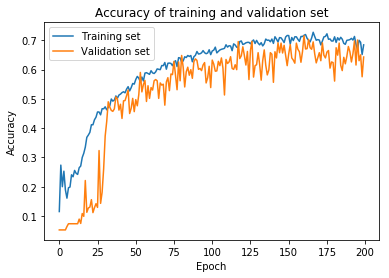

In [13]:
plt.plot(range(num_epochs), history.history['accuracy'])
plt.plot(range(num_epochs), history.history['val_accuracy'])
plt.title("Accuracy of training and validation set")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training set", "Validation set"])

### Metrics

In [14]:
label_map = (train_generator.class_indices)
label_map

{'B_A': 0,
 'B_F': 1,
 'B_PT': 2,
 'B_TA': 3,
 'M_DC': 4,
 'M_LC': 5,
 'M_MC': 6,
 'M_PC': 7}

In [18]:
model.evaluate(validation_generator)

30/30 [==============================] - 13s 436ms/step


[0.8513481616973877, 0.6427818536758423]

In [19]:
validation_generator.reset()
y_pred = model.predict_generator(
            validation_generator,
            verbose = 1)
y_pred = np.argmax(y_pred, axis=-1)

y_true = validation_generator.classes[validation_generator.index_array]

30/30 [==============================] - 13s 440ms/step


In [20]:
matrix = confusion_matrix(y_true,y_pred)
print(matrix)
print(np.diag(matrix)/np.sum(matrix,axis=1))
print(sum(np.diag(matrix))/np.sum(matrix))

[[ 30   2   2   7   1   0   8   1]
 [  3  62   8  28   4   1   4  11]
 [  1   7  18   8   6   2   0   8]
 [  0   3   0  66   1   0   0   0]
 [  0  22   1   7 276  49   9  55]
 [  1   1   1   0   9  55   2   4]
 [  0   8   0   8  14   4  50  13]
 [  0   3   1   2   8   1   0  53]]
[0.58823529 0.51239669 0.36       0.94285714 0.65871122 0.75342466
 0.51546392 0.77941176]
0.642781875658588
